# VAR(2,0) NumPyro Benchmark Example

In this notebook, we present how to implement and fit Bayesian Vector Autoregressive (VAR) models using [NumPyro](https://num.pyro.ai/en/stable/). We compare it with the `pymc-extras` implementation.

We use the data from `statsmodels` implementation from the [Vector Autoregressions tsa.vector_ar](https://www.statsmodels.org/stable/vector_ar.html) tutorial.

Based on the original notebook: https://juanitorduz.github.io/var_numpyro/

## Prepare Notebook


In [1]:
from functools import partial

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import pymc as pm
import pymc_extras.statespace as pmss
import pytensor.tensor as pt
import statsmodels.api as sm
import xarray as xr
from jax import jit, lax, random, vmap
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.handlers import condition
from numpyro.infer import MCMC, NUTS
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


## Load Data

We are going to use a dataset from the [`statsmodels` package](https://www.statsmodels.org/stable/datasets/index.html). Specifically, we will use the `macrodata` dataset from [Vector Autoregressions tsa.vector_ar](https://www.statsmodels.org/stable/vector_ar.html) tutorial. For the sake of reproducibility, we will keep the exact same code as in the tutorial.

In [2]:
def load_data() -> pd.DataFrame:
    mdata = sm.datasets.macrodata.load_pandas().data
    dates = mdata[["year", "quarter"]].astype(int).astype(str)
    quarterly = dates["year"] + "Q" + dates["quarter"]
    quarterly = dates_from_str(quarterly)
    mdata = mdata[["realgdp", "realcons", "realinv"]]
    mdata.index = pd.DatetimeIndex(quarterly, freq="QE")
    return np.log(mdata).diff().dropna()


data: pd.DataFrame = load_data()

We start by visualizing the data.

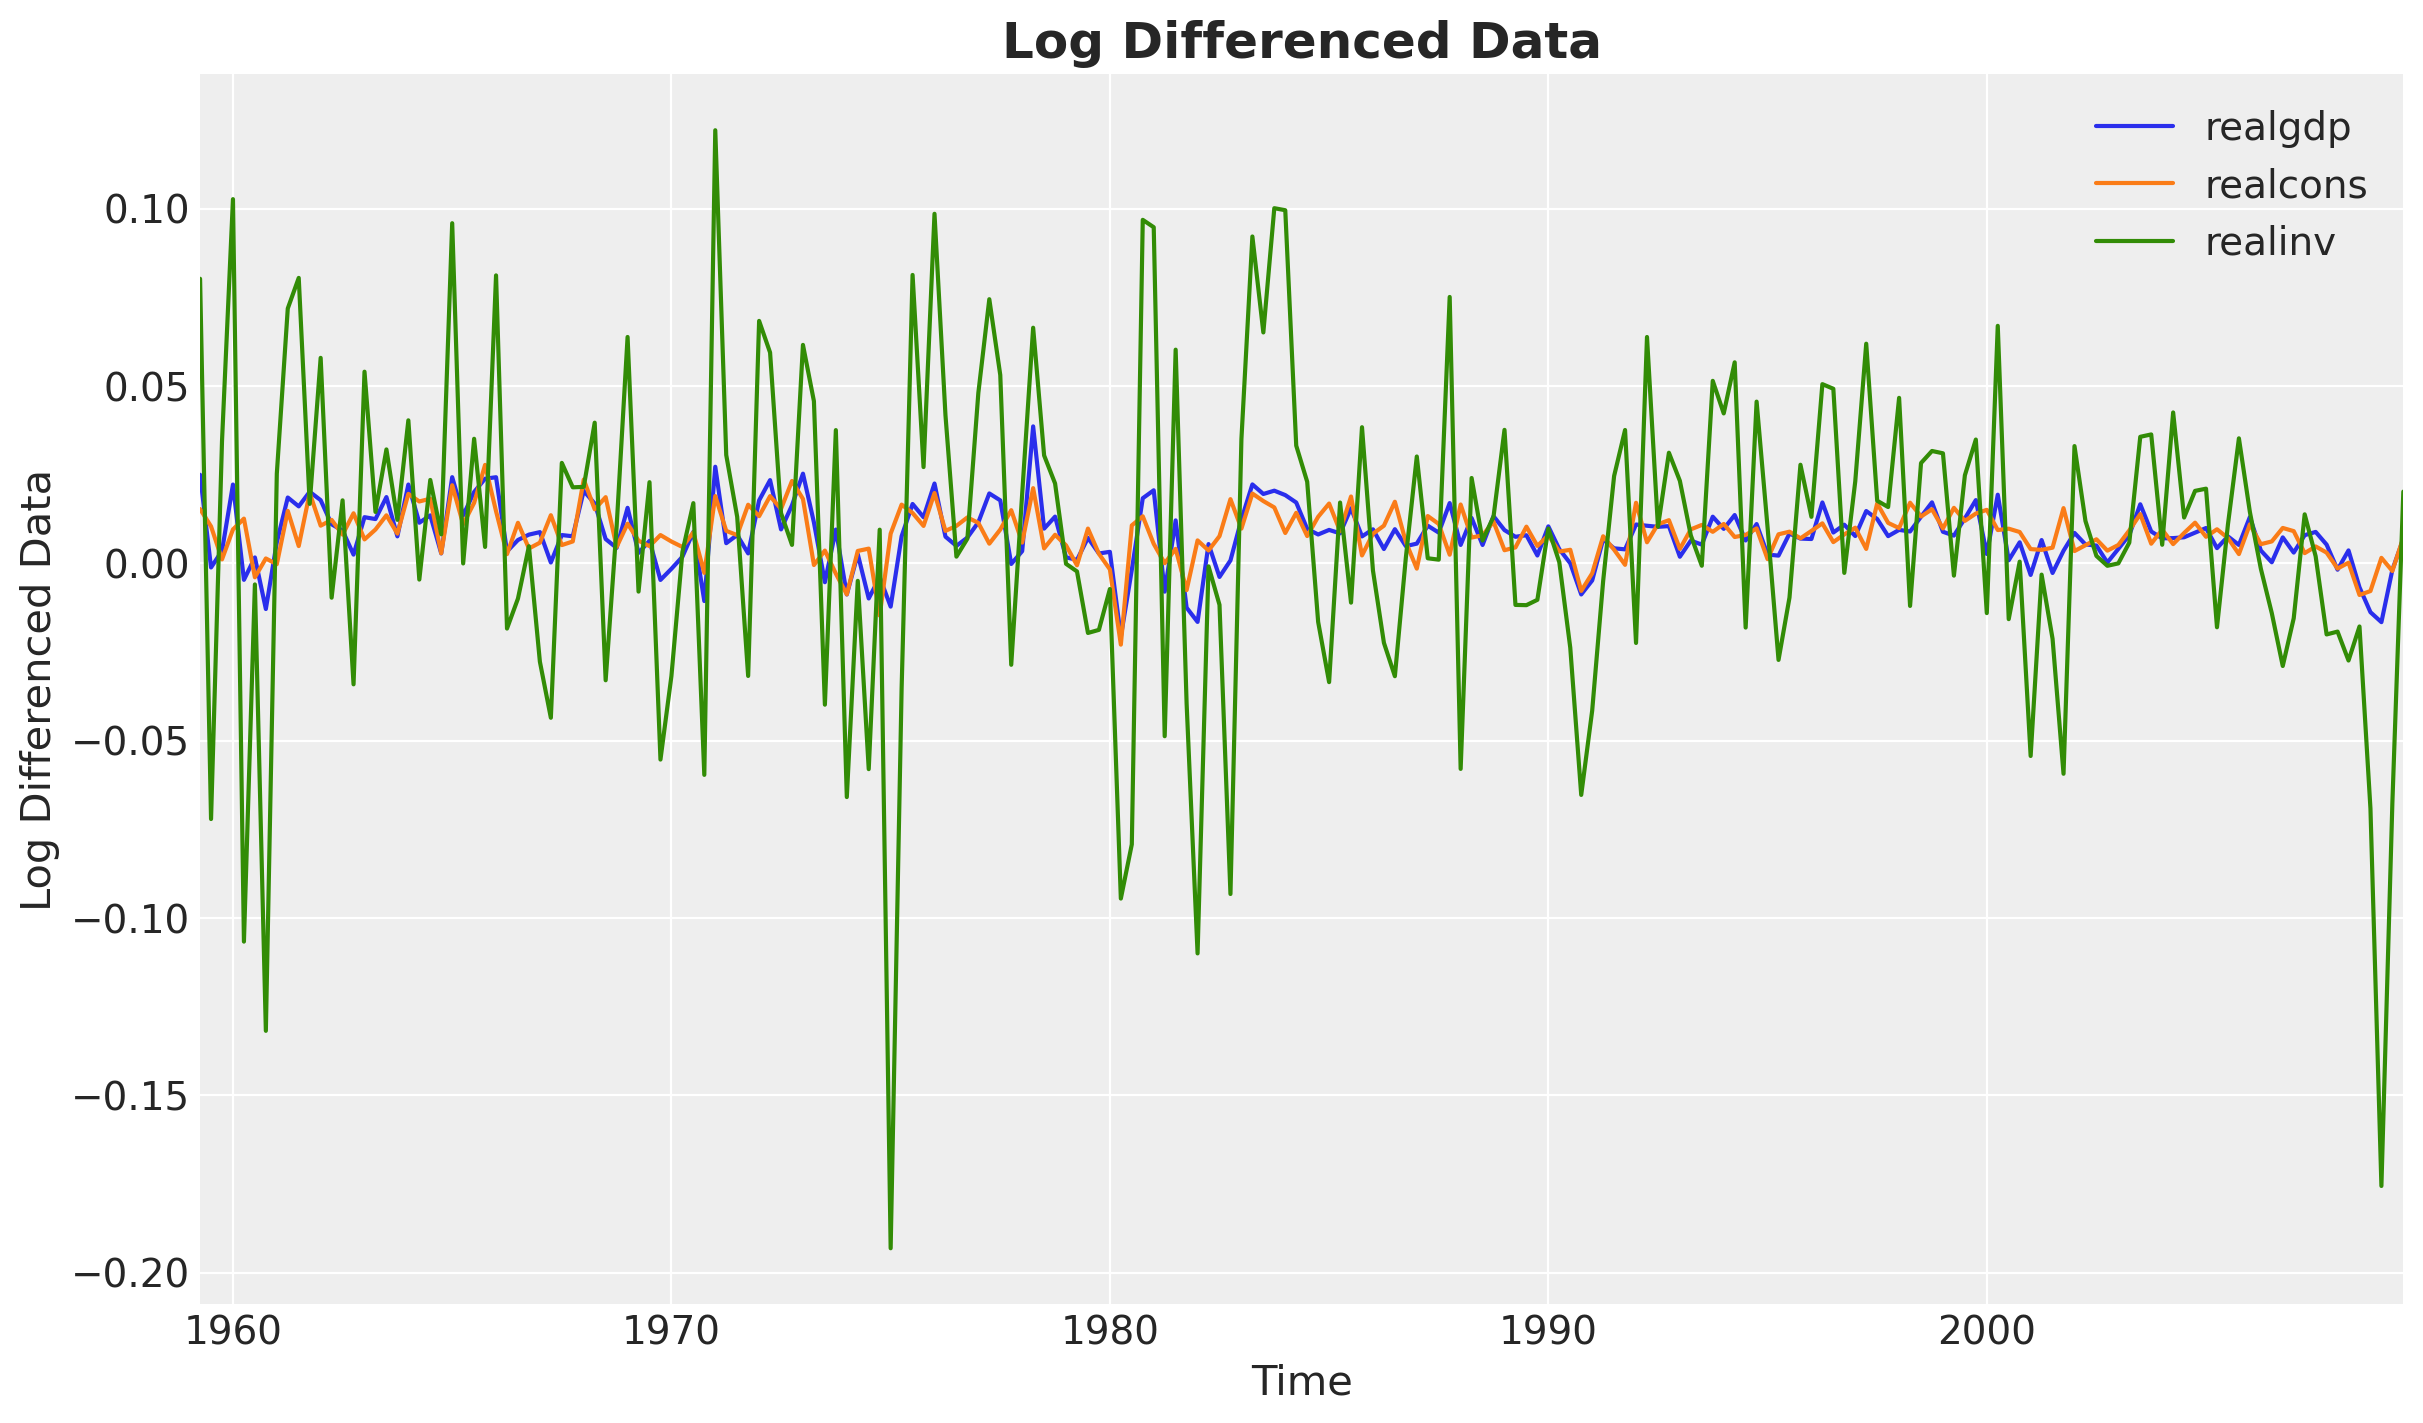

In [3]:
fig, ax = plt.subplots()
data.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Log Differenced Data")
ax.set_title("Log Differenced Data", fontsize=18, fontweight="bold");

It looks like the data is stationary.

## Fit VAR Model with Statsmodels


In [4]:
var_model = VAR(data)

var_results = var_model.fit(maxlags=2)

var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Dec, 2025
Time:                     19:51:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

## NumPyro Implementation



In [11]:
def model(y: Float[Array, "time vars"], n_lags: int, future: int = 0) -> None:
    # Get the number of time steps and variables
    n_time, n_vars = y.shape

    # --- Priors ---
    constant = numpyro.sample("constant", dist.Normal(loc=0, scale=1).expand([n_vars]))

    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1.0).expand([n_vars]))

    l_omega = numpyro.sample(
        "l_omega", dist.LKJCholesky(dimension=n_vars, concentration=1.0)
    )
    l_sigma = jnp.einsum("...i,...ij->...ij", sigma, l_omega)

    # Sample phi coefficients - shape (n_lags, n_vars, n_vars)
    # The first dimension is the lags, the second dimension is the variables on the rows
    # and the third dimension is the variables on the columns that
    # we want to multiply and sum.
    phi = numpyro.sample(
        "phi", dist.Normal(0, 10).expand([n_lags, n_vars, n_vars]).to_event(3)
    )

    # --- Transition Function ---

    def transition_fn(carry: Array, _, name: str) -> tuple[Array, Array]:
        # carry: (n_lags, n_vars)
        y_lags = carry

        # Compute lag contributions as a matrix product of phi and y_lags
        # (see the example above!)
        # Here the only trick is to reverse the phi lag coordinates. Why?
        # The first entry in the  initial `carry` vector `init_carry = y[:n_lags]`
        # is the oldest lag and the last entry is the newest lag.
        lag_contributions = jnp.einsum("lij,lj->i", phi[::-1], y_lags)
        # Compute VAR mean
        m_t = constant + lag_contributions

        # Sample observation
        y_t = numpyro.sample(name, dist.MultivariateNormal(loc=m_t, scale_tril=l_sigma))

        # Update carry: remove oldest, add newest
        new_carry = jnp.concatenate([y_lags[1:], y_t[None, :]], axis=0)
        return new_carry, y_t

    inference_fn = partial(transition_fn, name="y_pred")

    # Initialize and run scan
    init_carry = y[:n_lags]
    time_indices = jnp.arange(n_lags, n_time)

    with condition(data={"y_pred": y[n_lags:]}):
        scan(inference_fn, init=init_carry, xs=time_indices)

    if future > 0:
        prediction_fn = partial(transition_fn, name="y_future")
        scan(prediction_fn, init=y[-n_lags:], xs=jnp.arange(future))

Let's visualize the model:

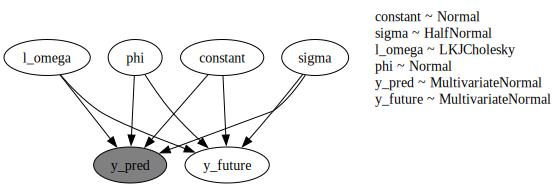

In [8]:
y: Float[Array, "time vars"] = jnp.array(data)
n_lags = 2
future = 30

numpyro.render_model(
    model,
    model_kwargs={"y": y, "n_lags": n_lags, "future": future},
    render_distributions=True,
    render_params=True,
)

Here we see the model structure and the two outputs: `y_pred` (inference) and `y_future` (prediction).

## Fit Numpyro Model

We now sample from the posterior distribution of the model using MCMC.

In [9]:
%%time

nuts_kernel = NUTS(model)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

# Run inference

rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, y=y, n_lags=n_lags, future=future)

# Get samples
samples = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 4.19 s, sys: 186 ms, total: 4.38 s
Wall time: 1.51 s


Let's parse the samples to an ArviZ InferenceData object.

In [12]:
idata = az.from_numpyro(
    mcmc,
    coords={
        "var_1": data.columns,
        "var_2": data.columns,
        "lag": range(1, n_lags + 1),
        "future": range(data.shape[0], data.shape[0] + future),
    },
    dims={
        "constant": ["var_1"],
        "sigma": ["var_1"],
        "l_omega": ["var_1", "var_2"],
        "phi": ["lag", "var_1", "var_2"],
        "y_future": ["future", "var_1"],
    },
)

We can now visualize the traces.

/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


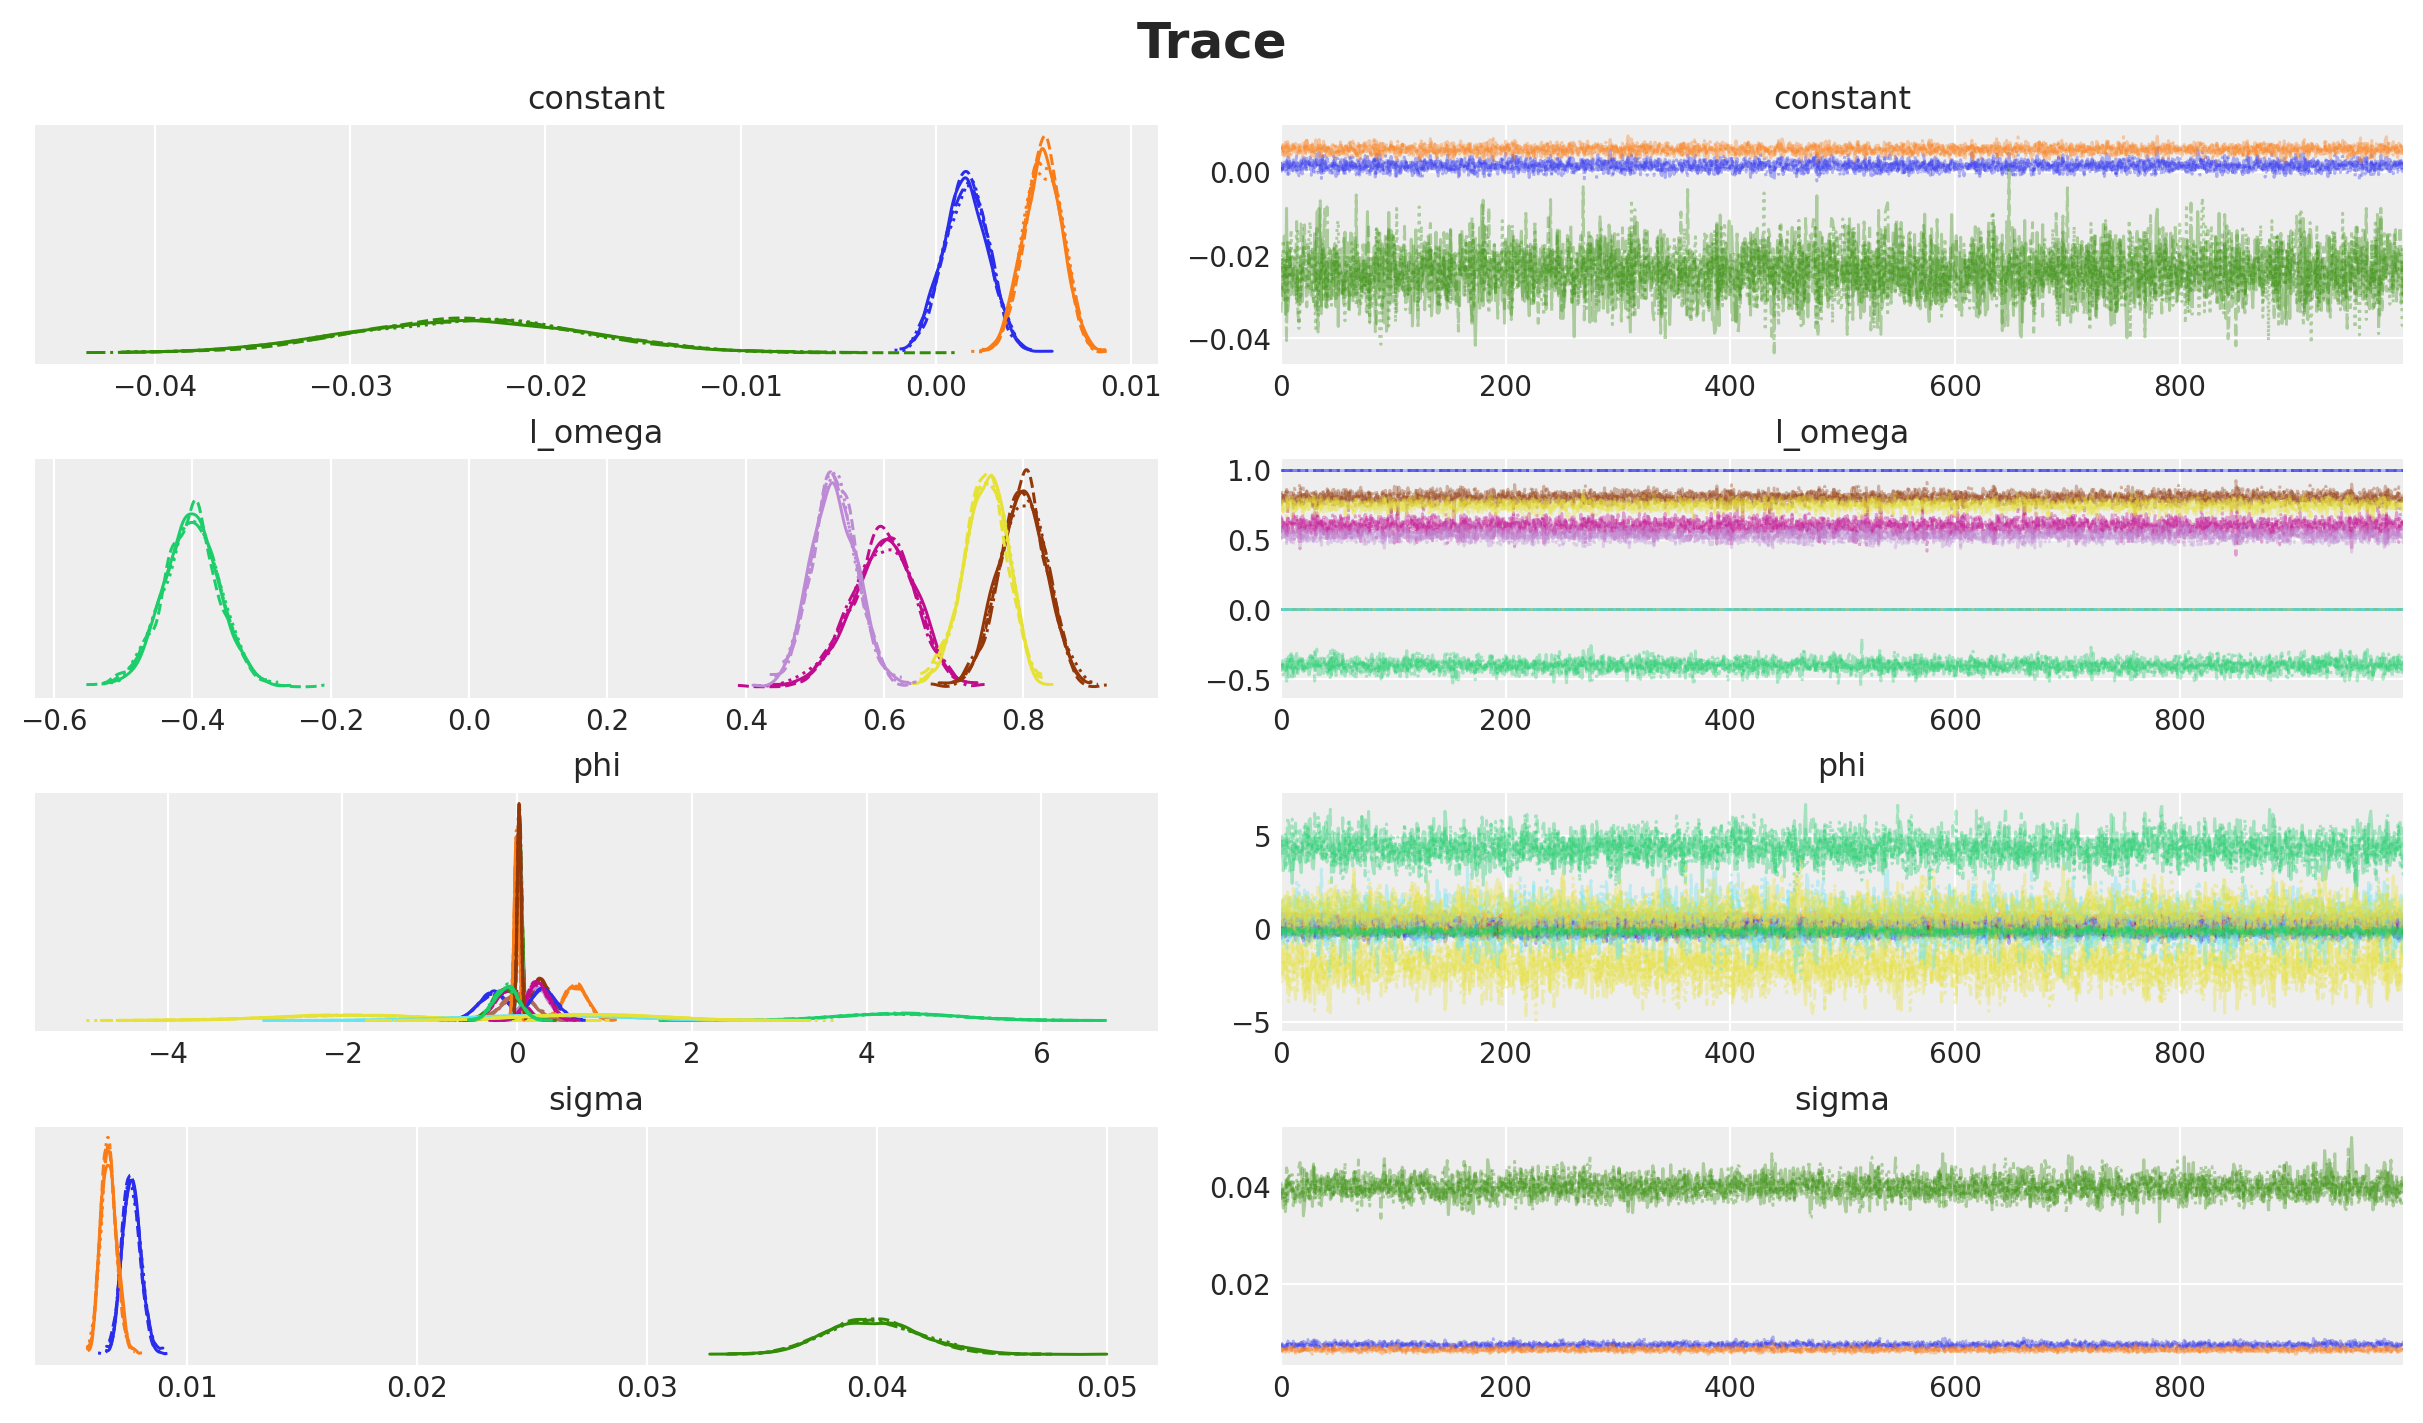

In [13]:
axes = az.plot_trace(
    data=idata,
    var_names=["~y_future"],
    compact=True,
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=18, fontweight="bold");

Overall, the chains seem to converge well.

## Parameter Comparison

We can manually inspect certain parameters mean values to see if they match the reference values from the `statsmodels` results.

In [14]:
(
    idata["posterior"]["phi"]
    .mean(dim=["chain", "draw"])
    .sel(var_1="realgdp")
    .to_dataframe()
    .sort_index()
)

var_1       phi
lag var_2                      
1   realcons  realgdp  0.664459
    realgdp   realgdp -0.267535
    realinv   realgdp  0.031618
2   realcons  realgdp  0.292080
    realgdp   realgdp  0.008296
    realinv   realgdp -0.006889

In [15]:
var_results.params["realgdp"].to_frame()

,realgdp
const,0.001527
L1.realgdp,-0.279435
L1.realcons,0.675016
L1.realinv,0.033219
L2.realgdp,0.008221
L2.realcons,0.290458
L2.realinv,-0.007321


We do see the values are very close 🚀!

Similarly, we can look into the correlation matrix:

In [16]:
l_omega_mean = idata["posterior"]["l_omega"].mean(dim=["chain", "draw"])

corr_mean = l_omega_mean.to_numpy() @ l_omega_mean.to_numpy().T

corr_mean

array([[1.        , 0.59765637, 0.7459593 ],
       [0.59765637, 0.9967496 , 0.12460324],
       [0.7459593 , 0.12460324, 0.9963157 ]], dtype=float32)

Which is very close to the correlation matrix from the `statsmodels` summary results above.

Finally, we can compare all the $\Phi$ parameters with the estimated posterior distributions.

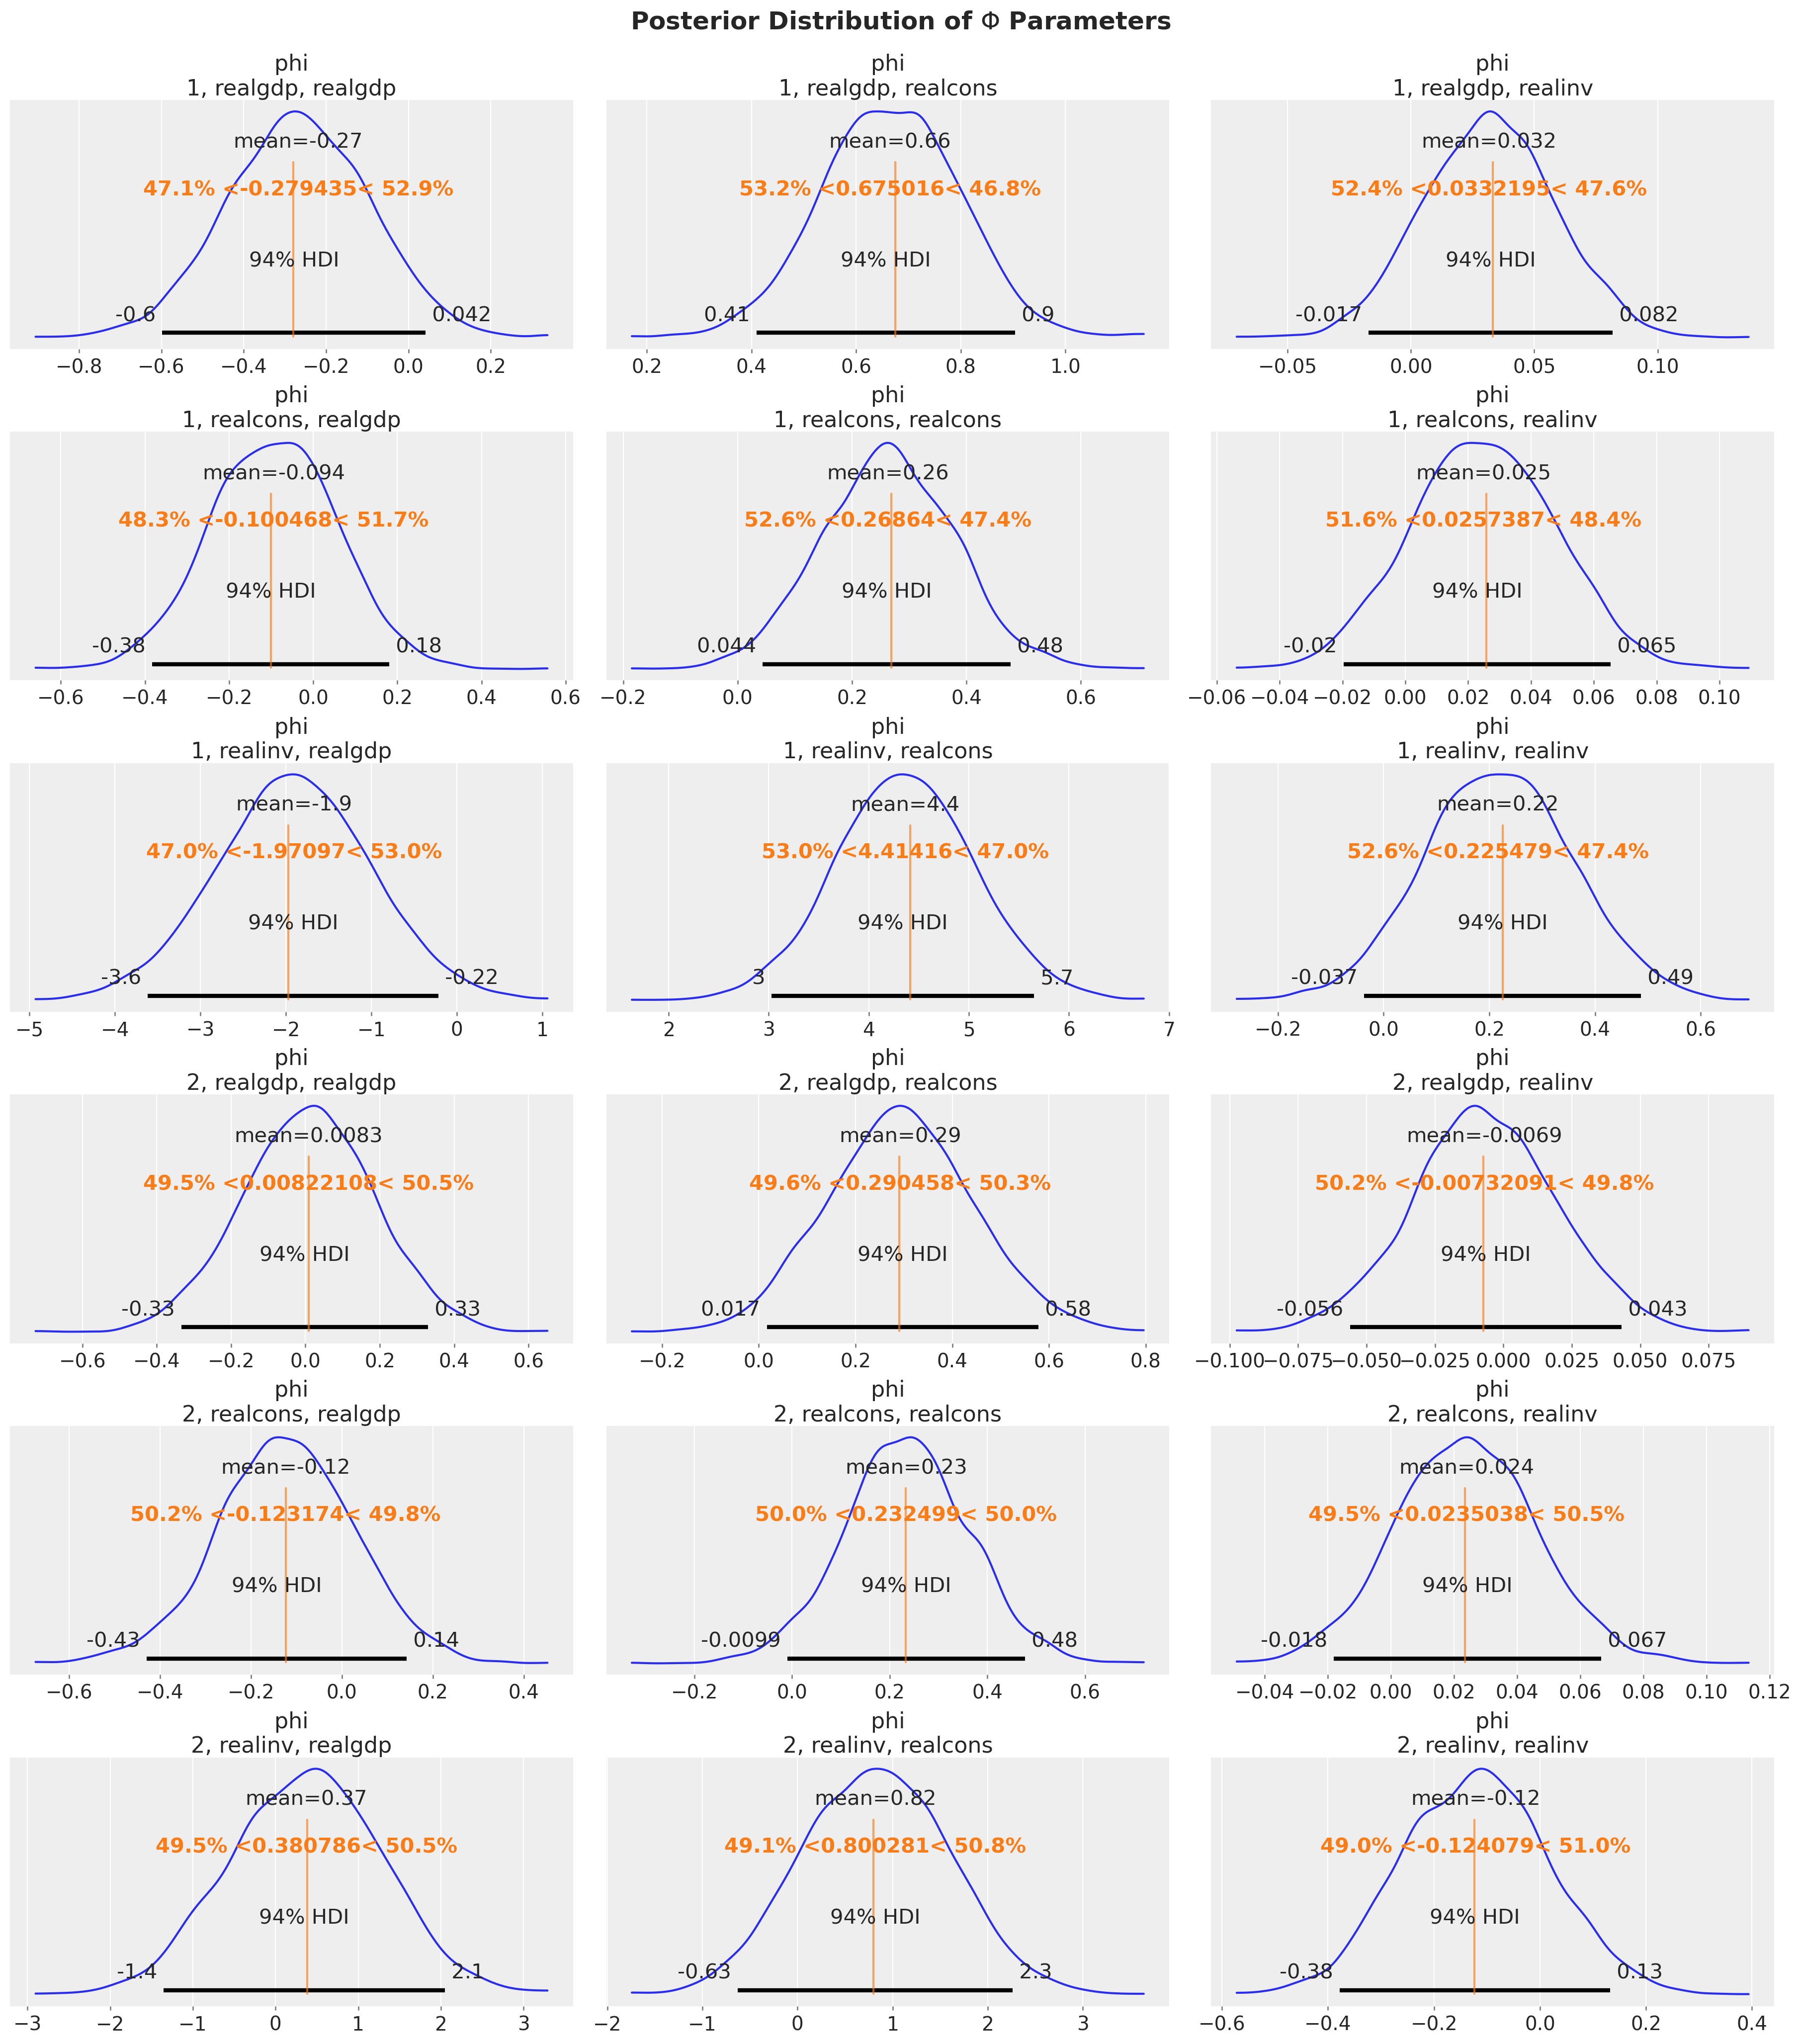

In [17]:
# Reference values from statsmodels VAR(2) results
# Simplified construction using list comprehension and f-strings
lags = range(2, 0, -1)
variables = data.columns

ref_vals_phi = {
    "phi": [
        {
            "lag": lag,
            "var_1": var_1,
            "var_2": var_2,
            "ref_val": var_results.params[var_1][f"L{lag}.{var_2}"],
        }
        for lag in lags
        for var_1 in variables
        for var_2 in variables
    ]
}

axes = az.plot_posterior(
    idata,
    var_names=["phi"],
    ref_val=ref_vals_phi,
    figsize=(18, 20),
)
fig = axes[0][0].figure
fig.suptitle(
    r"Posterior Distribution of $\Phi$ Parameters",
    fontsize=18,
    fontweight="bold",
    y=1.02,
);

All of the estimated parameters are very close to the reference values!

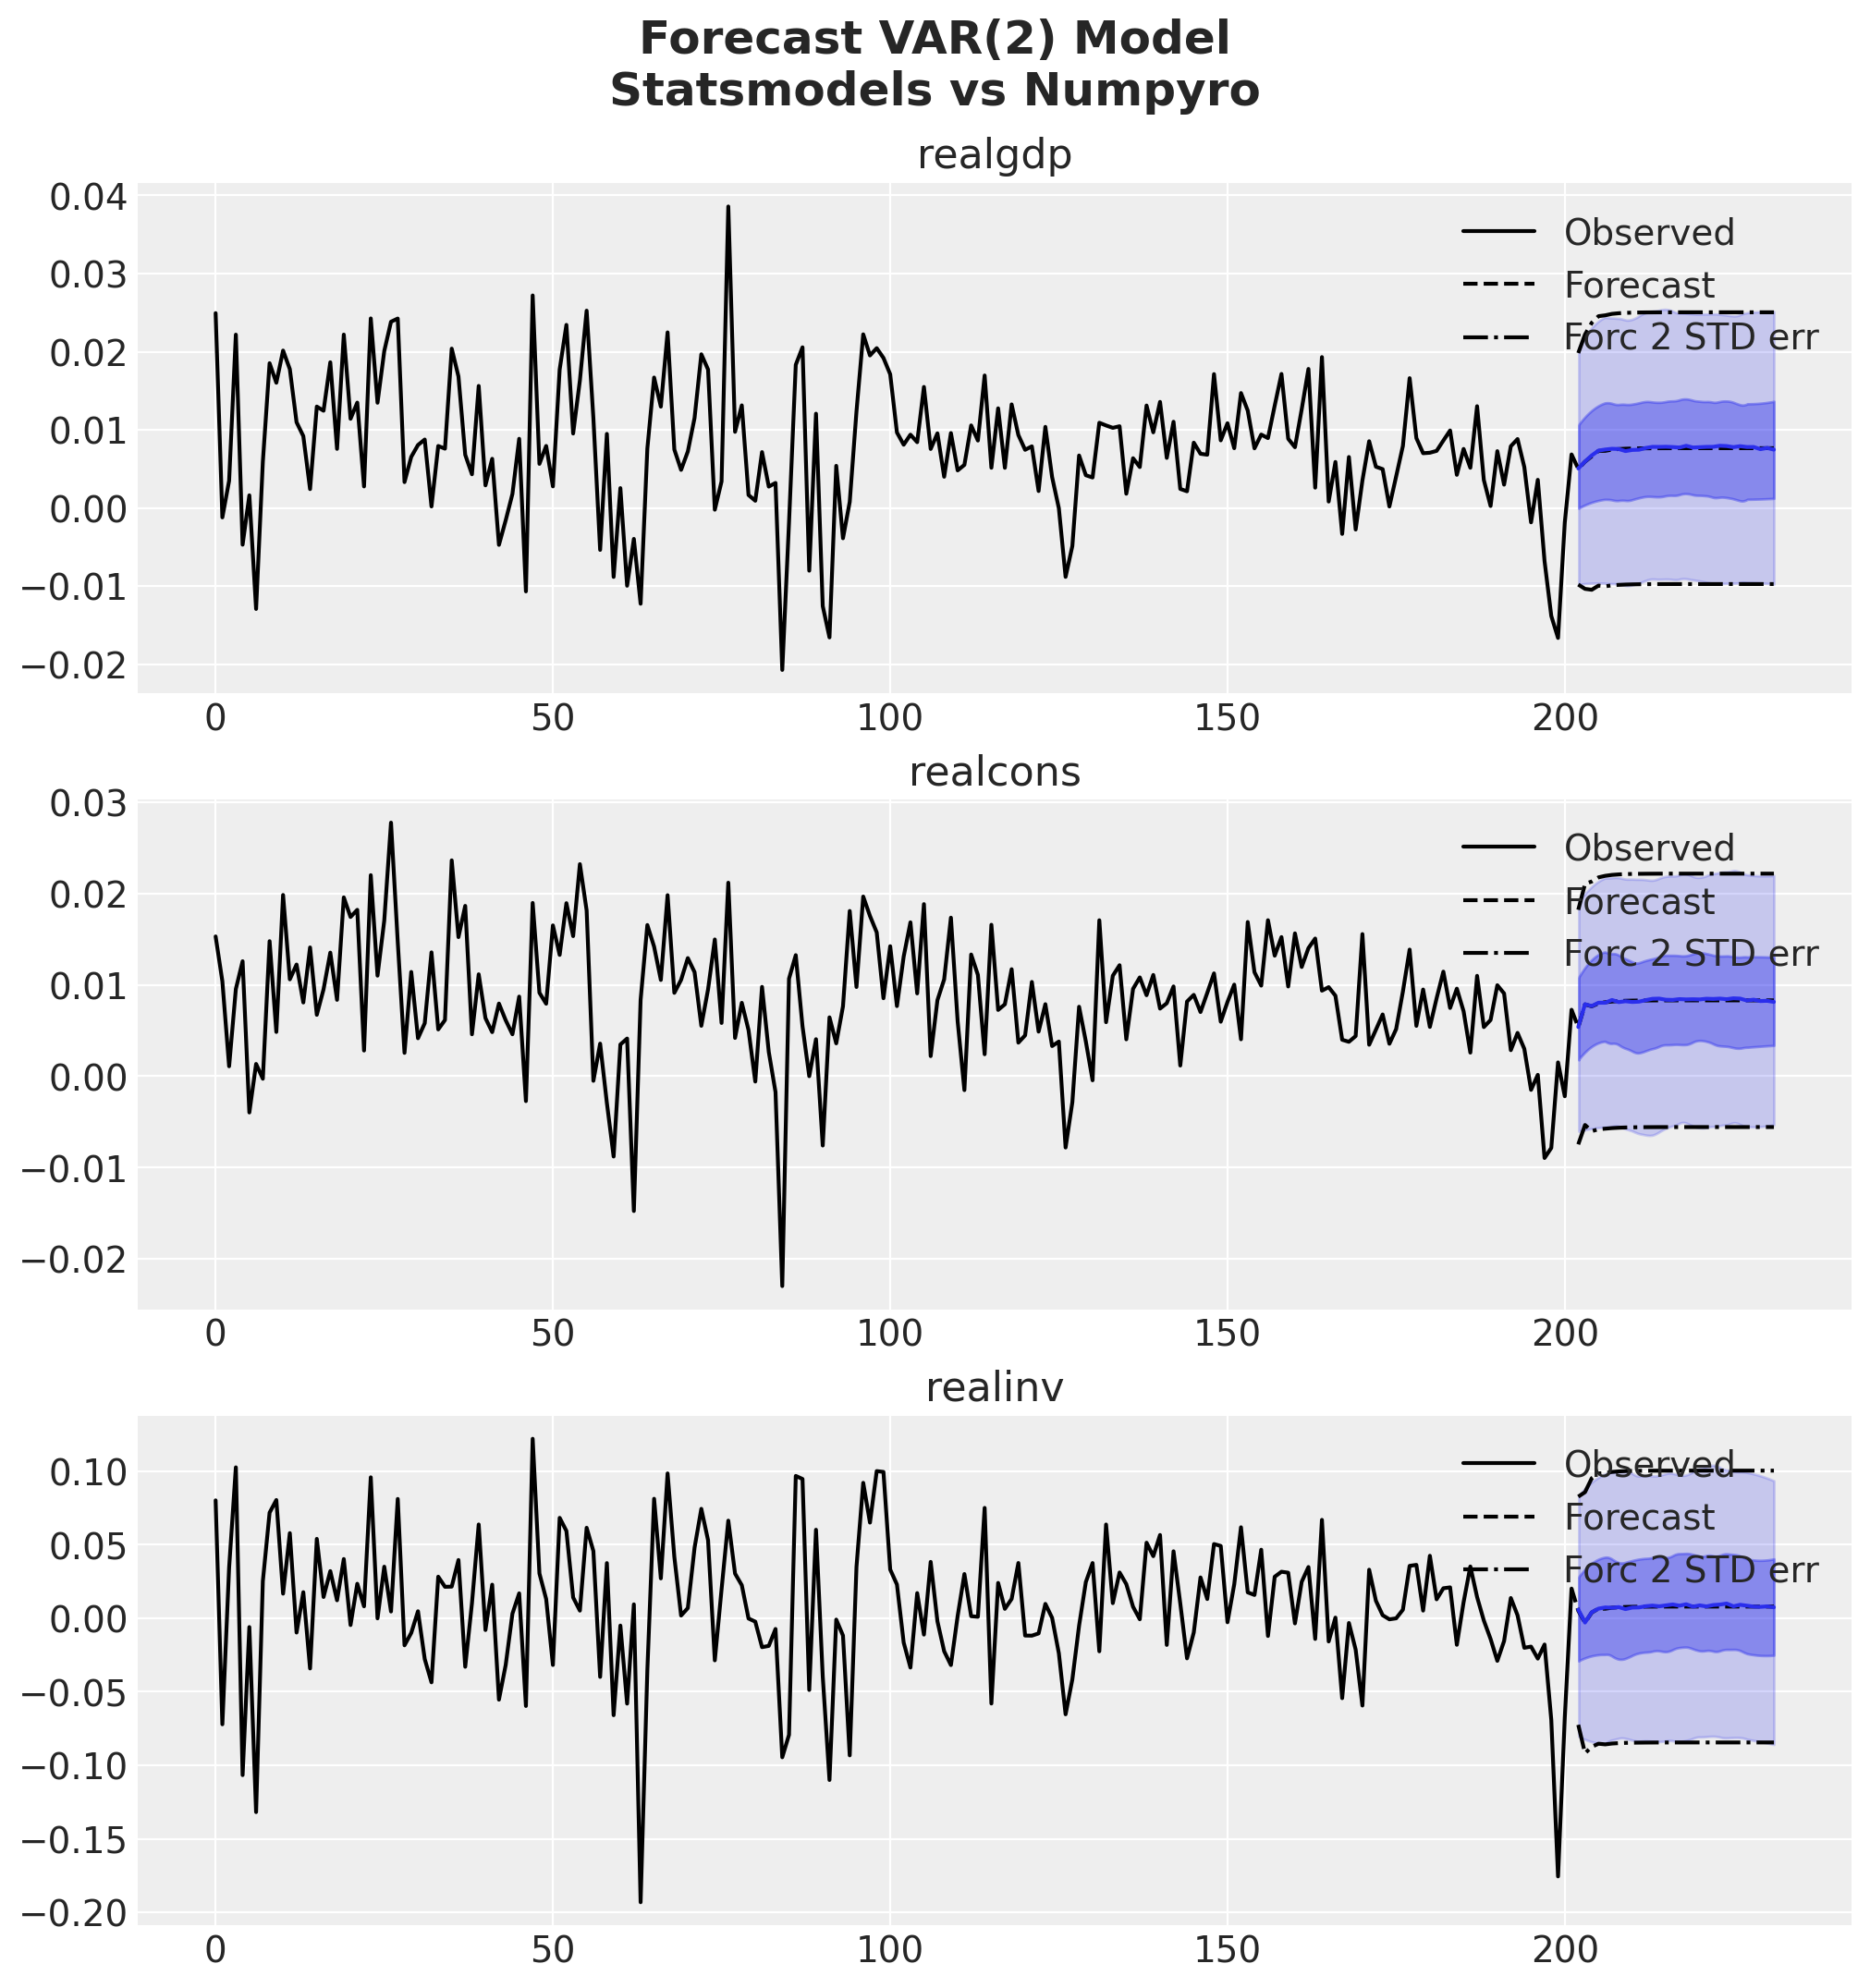

In [18]:
fig = var_results.plot_forecast(steps=future, alpha=0.05, plot_stderr=True)
axes = fig.get_axes()

t_future = idata["posterior"]["y_future"].coords["future"]

for var_idx, var in enumerate(data.columns):
    ax = axes[var_idx]
    for i, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            t_future,
            idata["posterior"]["y_future"].sel(var_1=var),
            color="C0",
            hdi_prob=hdi_prob,
            fill_kwargs={"alpha": 0.2 + 0.2 * i},
            ax=ax,
        )

    ax.plot(
        t_future,
        idata["posterior"]["y_future"].sel(var_1=var).mean(dim=["chain", "draw"]),
        color="C0",
    )

fig.suptitle(
    "Forecast VAR(2) Model\nStatsmodels vs Numpyro",
    fontsize=18,
    fontweight="bold",
    y=1.06,
);

## PyMC-Extras Implementation

                                          Model Requirements                                           
                                                                                                       
  Variable    Shape       Constraints                                                      Dimensions  
 ───────────────────────────────────────────────────────────────────────────────────────────────────── 
  x0          (6,)                                                                         ('state',)  
  P0          (6, 6)      Positive Semi-definite                               ('state', 'state_aux')  
  ar_params   (3, 2, 3)   None                     ('observed_state', 'lag_ar', 'observed_state_aux')  
  state_cov   (3, 3)      Positive Semi-definite                               ('shock', 'shock_aux')  
                                                                                                       
        These parameters should be assigned priors inside a PyMC model block before calling the        
                                    build_statespace_graph method.                                     

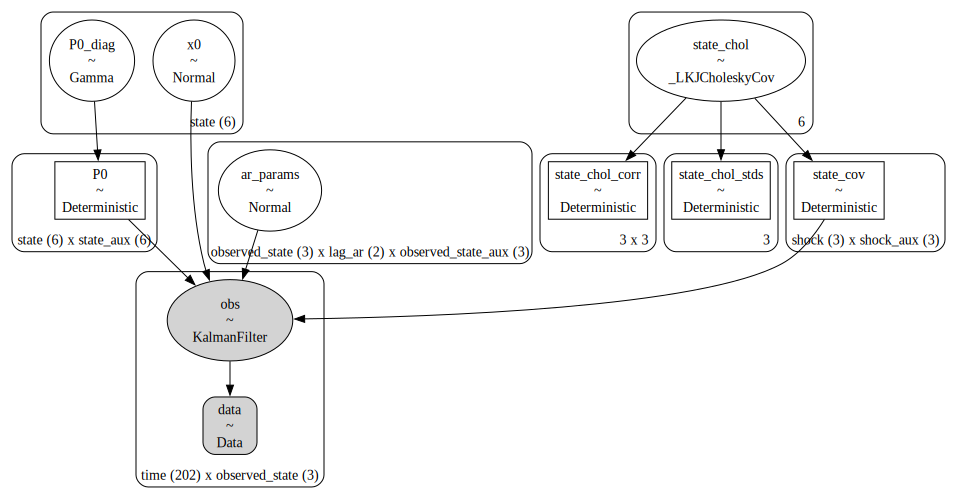

In [ ]:
# Taken from https://www.pymc.io/projects/extras/en/latest/statespace/generated/pymc_extras.statespace.models.BayesianVARMAX.html#pymc_extras.statespace.models.BayesianVARMAX
bvar_mod = pmss.BayesianVARMAX(
    endog_names=data.columns,
    order=(2, 0),
    stationary_initialization=False,
    measurement_error=False,
    filter_type="standard",
    verbose=True,
)

# Unpack dims and coords
x0_dims, P0_dims, state_cov_dims, ar_dims = bvar_mod.param_dims.values()
coords = bvar_mod.coords

# Estimate PyMC model
with pm.Model(coords=coords) as var_mod:
    x0 = pm.Normal("x0", dims=x0_dims)
    P0_diag = pm.Gamma(
        "P0_diag", alpha=2, beta=1, size=data.shape[1] * 2, dims=P0_dims[0]
    )
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=P0_dims)

    state_chol, _, _ = pm.LKJCholeskyCov(
        "state_chol", eta=1, n=bvar_mod.k_posdef, sd_dist=pm.HalfNormal.dist(sigma=1)
    )

    ar_params = pm.Normal("ar_params", mu=0, sigma=10, dims=ar_dims)
    state_cov = pm.Deterministic(
        "state_cov", state_chol @ state_chol.T, dims=state_cov_dims
    )

    bvar_mod.build_statespace_graph(data)

pm.model_to_graphviz(var_mod)

In [46]:
%%time

with var_mod:
    pm_idata = pm.sample(
        tune=1_000,
        draws=1_000,
        chains=4,
        nuts_sampler="nutpie",
        random_seed=42,
    )


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.11,63
,2000,0,0.10,63
,2000,0,0.11,127
,2000,0,0.11,127


CPU times: user 30min 8s, sys: 6.36 s, total: 30min 15s
Wall time: 7min 56s


The posterior mean of the $\Phi$ parameters matches the reference values from the `statsmodels` results.

In [68]:
idata["posterior"]["phi"].mean(dim=("chain", "draw")).sel(lag=1, var_1="realgdp")

<xarray.DataArray 'phi' (var_2: 3)> Size: 12B
array([-0.26753527,  0.66445893,  0.03161773], dtype=float32)
Coordinates:
  * var_2    (var_2) object 24B 'realgdp' 'realcons' 'realinv'
    var_1    <U7 28B 'realgdp'
    lag      int64 8B 1

In [69]:
idata["posterior"]["phi"].mean(dim=("chain", "draw"))

<xarray.DataArray 'phi' (lag: 2, var_1: 3, var_2: 3)> Size: 72B
array([[[-0.26753527,  0.66445893,  0.03161773],
        [-0.09398484,  0.26229334,  0.02491092],
        [-1.9074914 ,  4.363061  ,  0.2163417 ]],

       [[ 0.00829608,  0.2920795 , -0.00688933],
        [-0.12397188,  0.23339199,  0.02388903],
        [ 0.37268522,  0.8192956 , -0.12181345]]], dtype=float32)
Coordinates:
  * lag      (lag) int64 16B 1 2
  * var_1    (var_1) object 24B 'realgdp' 'realcons' 'realinv'
  * var_2    (var_2) object 24B 'realgdp' 'realcons' 'realinv'

In [71]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue, 30 Dec 2025

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.8.0

arviz      : 0.23.0
jax        : 0.8.2
jaxtyping  : 0.3.4
matplotlib : 3.10.8
numpy      : 2.3.5
numpyro    : 0.19.0
pandas     : 2.3.3
pymc       : 5.27.0
pymc_extras: 0.6.0
pytensor   : 2.36.1
statsmodels: 0.14.6
xarray     : 2025.12.0

Watermark: 2.6.0

